In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# making dataframe from UN Energy data
all_countries_df = pd.read_csv("resources/UNdata_Energy_PowerPlant.csv")

# making dataframe from scrapped african nations
african_countries_df = pd.read_csv("resources/african_nations.csv")

In [3]:
print("All nations: ", all_countries_df.info())
print("African nations: ", african_countries_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65990 entries, 0 to 65989
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country or Area          65990 non-null  object 
 1   Commodity - Transaction  65990 non-null  object 
 2   Year                     65988 non-null  float64
 3   Unit                     65988 non-null  object 
 4   Quantity                 65988 non-null  float64
 5   Quantity Footnotes       16029 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.0+ MB
All nations:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  54 non-null     object
dtypes: object(1)
memory usage: 560.0+ bytes
African nations:  None


### Cleaning Operations

In [4]:
## Dropping irelevant rows and columns
all_countries_df.drop([65988, 65989], inplace=True) 
all_countries_df.drop("Quantity Footnotes", axis=1, inplace=True)

In [5]:
# renaming column names for easier referencing
all_countries_df.rename(columns={"Country or Area":"country_or_area", "Commodity - Transaction":"commodity_transaction", "Year":"year", "Unit":"unit", "Quantity":"quantity"}, inplace=True)

In [6]:
all_countries_df.head()

,country_or_area,commodity_transaction,year,unit,quantity
0,Afghanistan,Electricity - total net installed capacity of ...,2020.0,"Kilowatts, thousand",537.0
1,Afghanistan,Electricity - total net installed capacity of ...,2019.0,"Kilowatts, thousand",531.0
2,Afghanistan,Electricity - total net installed capacity of ...,2018.0,"Kilowatts, thousand",519.0
3,Afghanistan,Electricity - total net installed capacity of ...,2017.0,"Kilowatts, thousand",519.0
4,Afghanistan,Electricity - total net installed capacity of ...,2016.0,"Kilowatts, thousand",519.0


In [7]:
## preparing dataset for merge with all nations

# renaming country column on african_countries_df
african_countries_df.rename(columns={"Country":"country_or_area"}, inplace=True)

In [8]:
# renaming country names in general dataframe to match name in african nations df
all_countries_df.country_or_area.replace({"United Rep. of Tanzania":"Tanzania", "Dem. Rep. of the Congo":"DR Congo", 
                                    "Sao Tome and Principe":"Sao Tome & Principe", "Central African Rep.":"Central African Republic"}, inplace=True)

#### Merging datasets

In [9]:
africa_plants = all_countries_df.merge(african_countries_df, on="country_or_area")

#### Verifying state of new dataset with further cleaning

In [10]:
print(africa_plants.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12969 entries, 0 to 12968
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country_or_area        12969 non-null  object 
 1   commodity_transaction  12969 non-null  object 
 2   year                   12969 non-null  float64
 3   unit                   12969 non-null  object 
 4   quantity               12969 non-null  float64
dtypes: float64(2), object(3)
memory usage: 607.9+ KB
None


In [12]:
africa_plants.duplicated().sum()

0

In [13]:
africa_plants.describe()

,year,quantity
count,12969.000000,12969.000000
mean,2005.851261,1212.357545
std,8.822248,4771.924297
min,1990.000000,0.000000
25%,1998.000000,23.000000
50%,2007.000000,95.000000
75%,2014.000000,498.000000
max,2020.000000,59530.000000


In [14]:
# reformatting year column to workable string values

africa_plants.year = africa_plants.year.astype(str)
africa_plants.year = africa_plants.year.apply(lambda x: x.split('.')[0])

<small>year column was converted to string instead of datetime column because incorrect years were obtained using datetime method</small>

In [15]:
# fixing solar entires
africa_plants["commodity_transaction"].replace({"Electricity - net installed capacity of electric power plants public solar":
                                        "Electricity - net installed capacity of electric power plants, public solar"}, inplace=True)

In [16]:
# subsetting dataset of reported net capacity of plants
africa_net_capacity_plants = africa_plants.copy()
africa_net_capacity_plants = africa_net_capacity_plants[africa_net_capacity_plants.commodity_transaction.str.contains(",")]
# only net capacity electric power plants contains commas in dataset

In [17]:
# getting fuel source used in power plants
africa_net_capacity_plants.commodity_transaction = africa_net_capacity_plants.commodity_transaction.apply(lambda x:x.split(',')[1])

In [18]:
# unique energy sources
africa_net_capacity_plants.commodity_transaction.unique()

array([' main activity & autoproducer', ' hydro', ' public hydro',
       ' combustible fuels', ' public combustible fuels',
       ' self-producer combustible fuels', ' wind', ' public wind',
       ' solar', ' public solar', ' main activity', ' autoproducer',
       ' self-producer hydro', ' self-producer solar', ' geothermal',
       ' public geothermal', ' self-producer geothermal',
       ' self-producer wind', ' nuclear', ' public nuclear'], dtype=object)

In [19]:
# removing space before actual value
africa_net_capacity_plants.commodity_transaction = africa_net_capacity_plants.commodity_transaction.apply(lambda x:x[1:])

In [20]:
# merging same fuel sources even if they are of public or private generation, exempting self-producing plants, however.

africa_net_capacity_plants.commodity_transaction.replace({"public combustible fuels":"combustible fuels", 
                                        "public hydro":"hydro", "public wind":"wind", "public nuclear":"nuclear", 
                                        "public geothermal":"geothermal", "public solar":"solar"}, inplace=True)

<small>Before merging of fuels I discovered that same fuel sources had duplicated records. Merging the fuels revealed this abnormally</small>

In [21]:
africa_net_capacity_plants.duplicated().sum()

1980

In [22]:
# dropping duplicate records
africa_net_capacity_plants.drop_duplicates(inplace=True)
africa_net_capacity_plants.nunique()

country_or_area            54
commodity_transaction      14
year                       31
unit                        1
quantity                 2840
dtype: int64

### Univariate Plots

distribution of quantity

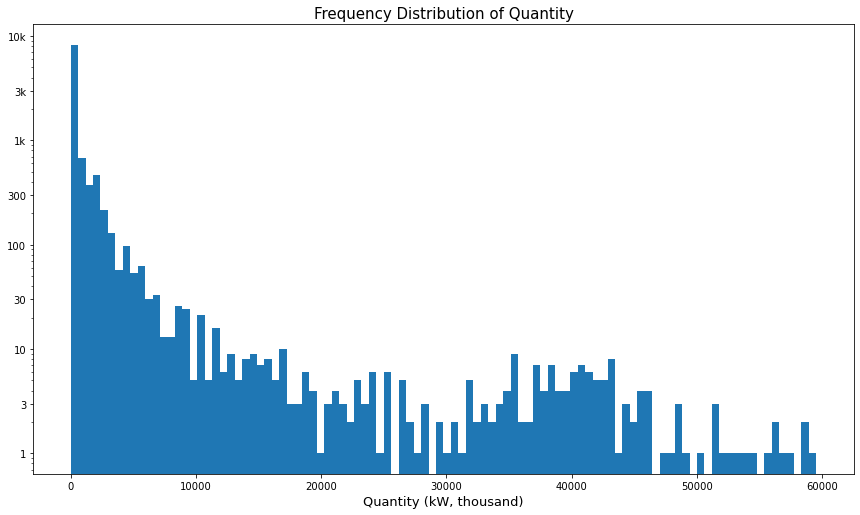

In [23]:
plt.figure(figsize=[14.70,8.27])

plt.hist(data=africa_net_capacity_plants, x='quantity', bins=100)
plt.xlabel('Quantity (kW, thousand)', fontdict={'fontsize':13})
plt.yscale('log')
plt.yticks([1e0, 3e0, 1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4], [1, 3, 10, 30, 100, 300, '1k', '3k', '10k'])

plt.title("Frequency Distribution of Quantity", fontdict={'fontsize':15})
plt.show()

* The Quantity variable is of unimodal distribution
* Most of the power plants have generation capacities between 0 (kW, thousand) to 10,000 (kW, thousand). 

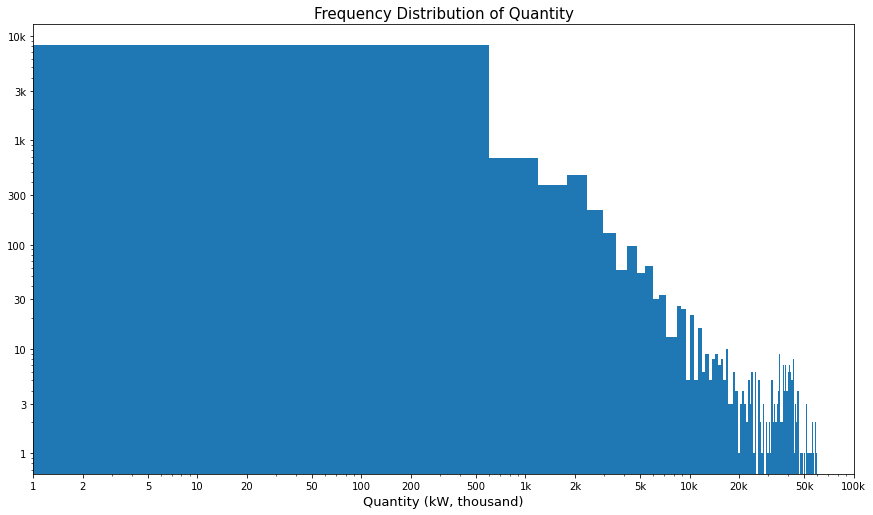

In [24]:
plt.figure(figsize=[14.70,8.27])

plt.hist(data=africa_net_capacity_plants, x='quantity', bins=100)
plt.xlabel('Quantity (kW, thousand)', fontdict={'fontsize':13})
plt.yscale('log')
plt.yticks([1e0, 3e0, 1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4], [1, 3, 10, 30, 100, 300, '1k', '3k', '10k'])
plt.xscale('log')
plt.xticks([1e0, 2e0, 5e0, 1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5], 
            [1, 2, 5, 10, 20, 50, 100, 200, 500, '1k', '2k', '5k', '10k', '20k', '50k', '100k'])

plt.title("Frequency Distribution of Quantity", fontdict={'fontsize':15})
plt.show()

* Closer looks reveals plants delivering capacities of 0 (kW, thousand) to >500 (kW, thousand) are of the modal class, there is a steep down and steady decline afterwards

In [25]:
general_plants = africa_net_capacity_plants[~(africa_net_capacity_plants.commodity_transaction.str.contains("self-producer|autoproducer|main"))]

In [26]:
general_plants.commodity_transaction.value_counts()

combustible fuels    2698
hydro                1400
solar                 489
wind                  253
geothermal             60
nuclear                30
Name: commodity_transaction, dtype: int64

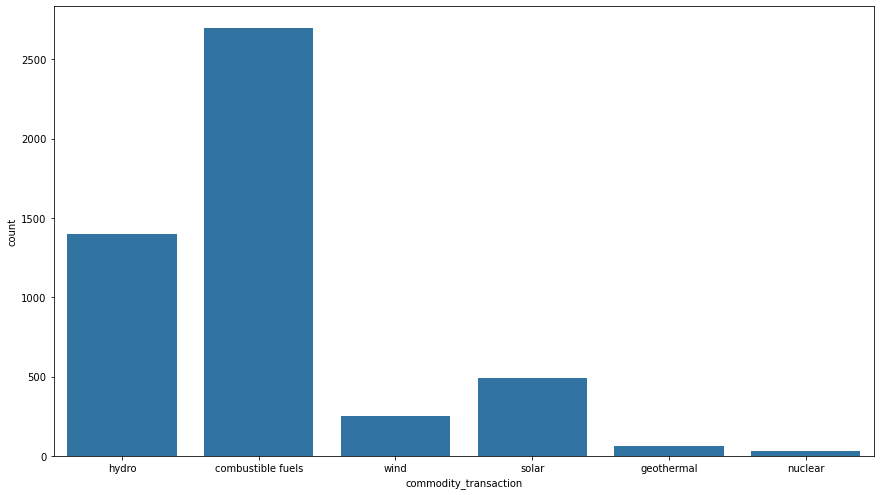

In [27]:
# countplot of energy sources
plt.figure(figsize=[14.70, 8.27])
sns.countplot(x='commodity_transaction', data=general_plants, color=sns.color_palette()[0])
plt.show()

* Combustible fuels power plants are the most numerous on the continent, followed by Hydro which makes sense seeing those are the technologies, she started with.

### Bivariate Plots

In [29]:
# Plants vs. Quantity
plt.figure(figsize=[14.70, 8.27])

sns.barplot(x='quantity', y='commodity_transaction', data=africa_net_capacity_plants, 
            color=sns.color_palette()[0], order=africa_net_capacity_plants.sort_values("quantity", ascending=False).commodity_transaction)
plt.show()

In [ ]:
# Quantity vs. Fuels
plt.figure(figsize=[14.70, 8.27])
# general_plants.plot(kind='bar', x='quantity', y='commodity_transaction')
sns.barplot(data=general_plants, x='commodity_transaction', y='quantity', color=sns.color_palette()[0])

plt.show()

<small>
Observation:
<ul>
<li>Main activity plants and a combination of main activity and autoproducer plants make up highest electricity productions,
but sadly, energy source used isn't specified</li>
<li>Nuclear and combustibles make the highest productions for known sources</li>
</ul>
</small>

### Multivariate Explorations

#### Functions